# Разведочный анализ данных

### Импорт библиотек

In [1]:
import os
import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка данных

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/aiedu-courses/eda_and_dev_tools/refs/heads/main/datasets/abalone.csv"

In [3]:
df = pd.read_csv(DATASET_URL)

## Общее исследование, очистка данных

### Описание данных

* `Sex` - пол особи (M/F/I)
* `Length` - длина ракушки (мм)
* `Diameter` - диаметр перпендикулярно длине (мм)
* `Height` - высота (мм)
* `Whole weight` - масса всего абалона (г)
* `Shucked weight` - масса без ракушки (г)
* `Viscera weight` - масса внутренностей (г)
* `Shell weight` - масса ракушки после сушки (г)
* `Rings` - количество колец (возраст приблизительно равен количеству колец + 1.5)

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Посмотрим на количество данных

In [5]:
df.shape

(4177, 9)

Выведем общую информацию о датасете

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [7]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
mean,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,9.933684
std,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [8]:
df.describe(include="object")

,Sex
count,4177
unique,4
top,M
freq,1447


Итак, у нас 8 количественных столбцов и 1 категорильный. Начнём с него

Посмотрим на значения в столбце `Sex`

In [9]:
df["Sex"].value_counts()

Sex
M    1447
I    1276
F    1259
f     195
Name: count, dtype: int64

Как видно, в данных присутствуют значения `M` (Male), `F` (Female) и `I` (Infant)  
Однако, среди них появилось значение `f`, что, вероятнее всего, является ошибкой при разметке. Исправим это, заменив `f` на `F`

In [10]:
df["Sex"] = df["Sex"].apply(lambda x: x.upper())

In [11]:
df["Sex"].value_counts()

Sex
F    1454
M    1447
I    1276
Name: count, dtype: int64

В описании данных были замечены нулевые значения в колонке `Height`. Высота не может равняться нулю, это явная ошибка

In [12]:
df["Height"].min()

np.float64(0.0)

Посмотрим на эти записи

In [13]:
df.query("Height == 0")

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


Некорректных значений мало, поэтому можно просто убрать их из датасета

In [14]:
df = df.query("Height > 0")

Исследуем пропущенные значения

In [15]:
df.isna().sum()

Sex                0
Length             0
Diameter          99
Height             0
Whole weight      99
Shucked weight     0
Viscera weight     0
Shell weight      50
Rings              0
dtype: int64

В данных есть пропущенные значения в столбцах `Diameter`, `Whole weight` и `Shell weight`

In [16]:
df[df.isna().any(axis=1)]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
43,I,0.205,0.150,0.055,NaN,0.0255,0.0150,0.012,5
64,M,0.520,NaN,0.120,0.5800,0.2340,0.1315,0.185,8
102,M,0.530,0.435,0.160,NaN,0.3160,0.1640,0.335,15
127,I,0.385,NaN,0.085,0.2505,0.1120,0.0610,0.080,8
...,...,...,...,...,...,...,...,...,...
4128,M,0.555,0.435,0.145,NaN,0.4040,0.2275,0.255,8
4138,M,0.630,0.490,0.155,NaN,0.5350,0.2900,0.335,11
4143,F,0.655,NaN,0.220,1.3590,0.6420,0.3255,0.405,13
4163,I,0.390,NaN,0.085,0.3440,0.1810,0.0695,0.079,7


In [17]:
f"{100 * len(df[df.isna().any(axis = 1)]) / len(df)}%"

'5.796407185628743%'

Строки с пропущенными значениями составляют более 5% от всего датасета.  
Есть смысла заменить пропущенные значения медианой

In [18]:
df.fillna(
    {
        "Diameter": df["Diameter"].median(),
        "Whole weight": df["Whole weight"].median(),
        "Shell weight": df["Shell weight"].median(),
    },
    inplace=True
)
df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

Проверим, есть ли в данных дубликаты

In [19]:
df.duplicated().sum()

np.int64(0)

Дубликатов нет, можно переиндексировать данные

In [20]:
df.reset_index(drop=True, inplace=True)

Сохраним очищенный датасет для дальнейшей работы с ним

In [21]:
clean_data_path = Path("data/abalone_clean.csv")
df.to_csv(clean_data_path, index=False)

## Однофакторный анализ

Построим распределение значений столбцов

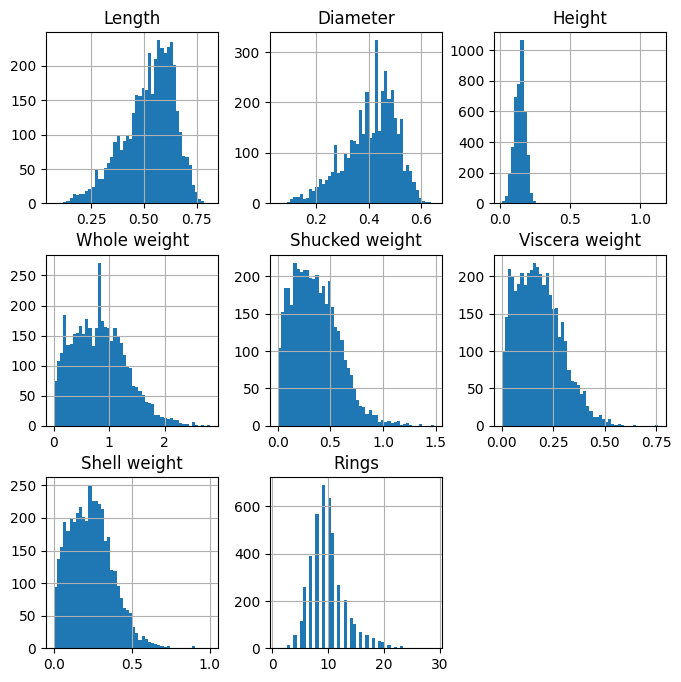

In [22]:
df.hist(bins=50, figsize=(8,8));

На части графиков видна правосторонняя ассиметрия

Наша целевая переменная - `Rings`. Посмотрим, как на неё влияют другие переменные

#### Length

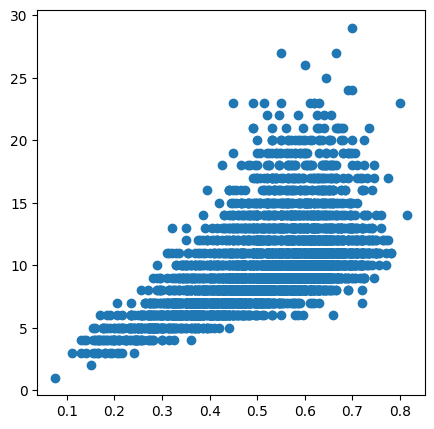

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(df["Length"], df["Rings"]);

In [24]:
np.corrcoef(df["Length"], df["Rings"])[0][1]

np.float64(0.5564643758735187)

Между значениями `Length` и `Rings` есть положительная корреляция  
Это ожидаемый результат, так как при взрослении особи увеличиваются её размеры

#### Diameter

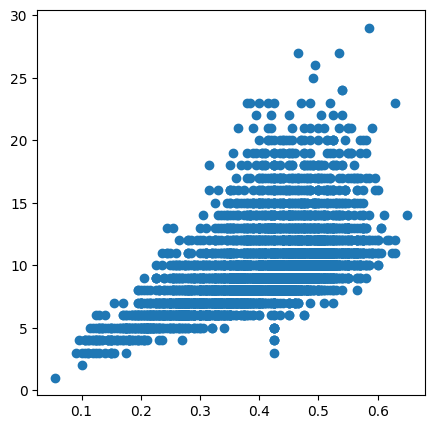

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(df["Diameter"], df["Rings"]);

In [26]:
np.corrcoef(df["Diameter"], df["Rings"])[0][1]

np.float64(0.5632615655648365)

Здесь тоже прослеживается положительная корреляция

#### Height

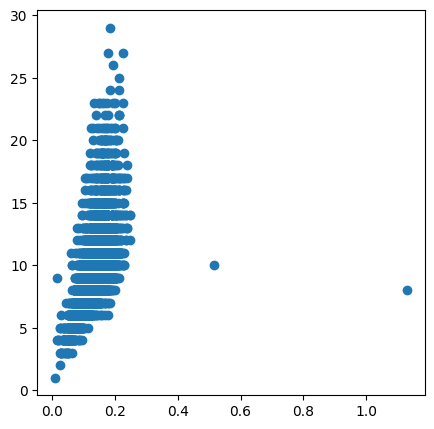

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(df["Height"], df["Rings"]);

In [28]:
df["Height"].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

count    4175.000000
mean        0.139583
std         0.041725
min         0.010000
25%         0.115000
50%         0.140000
75%         0.165000
95%         0.200000
max         1.130000
Name: Height, dtype: float64

In [29]:
df.query("Height > 0.4")

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1416,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10
2050,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8


Судя по графику, в данных присутствуют аномальные значения столбца `Height`  
Только две точки превышают значение 0.4, при этом одна из них больше 1.0

In [30]:
np.corrcoef(df["Height"], df["Rings"])[0][1]

np.float64(0.5576245544855893)

Тем не менее, между `Height` и `Rings` также прослеживается положительная корреляция

#### Whole weight

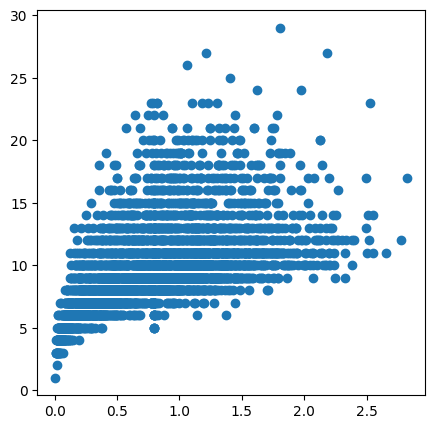

In [31]:
plt.figure(figsize=(5,5))
plt.scatter(df["Whole weight"], df["Rings"]);

In [32]:
np.corrcoef(df["Whole weight"], df["Rings"])[0][1]

np.float64(0.5319102932776798)

Между `Whole weight` и `Rings` видна положительная корреляция

#### Shucked weight

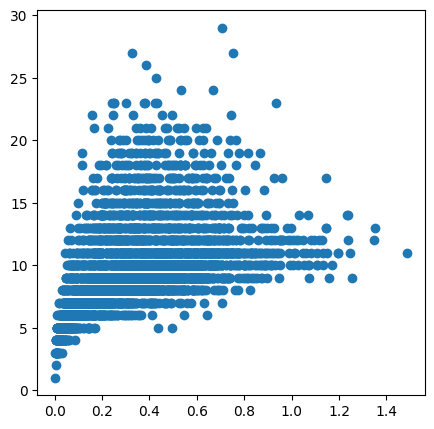

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(df["Shucked weight"], df["Rings"]);

In [34]:
np.corrcoef(df["Shucked weight"], df["Rings"])[0][1]

np.float64(0.420597393917105)

Заметно, что `Shucked weight` и `Rings` имеют положительную корреляцию.  
Однако, менее выраженную, чем `Rings` с другими рассмотренными параметрами

#### Viscera weight

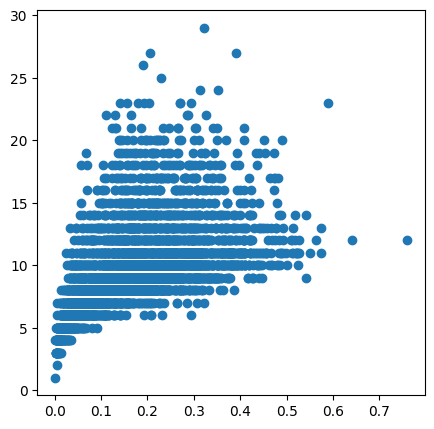

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(df["Viscera weight"], df["Rings"]);

In [36]:
np.corrcoef(df["Viscera weight"], df["Rings"])[0][1]

np.float64(0.5035622312738305)

Положительная корреляция видна также между `Viscera weight` и `Rings`

#### Shell weight

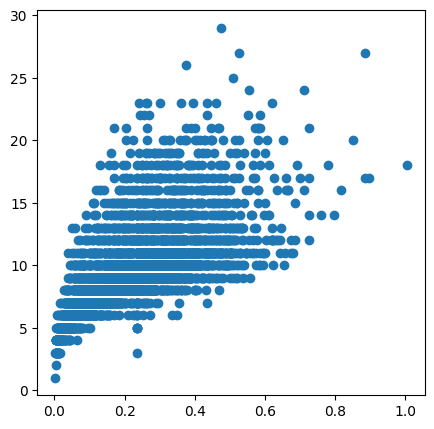

In [37]:
plt.figure(figsize=(5,5))
plt.scatter(df["Shell weight"], df["Rings"]);

In [38]:
np.corrcoef(df["Shell weight"], df["Rings"])[0][1]

np.float64(0.6225471701312042)

Среди количественных признаков самая выраженная положительная корреляция прослеживается с `Shell weight`

#### Sex

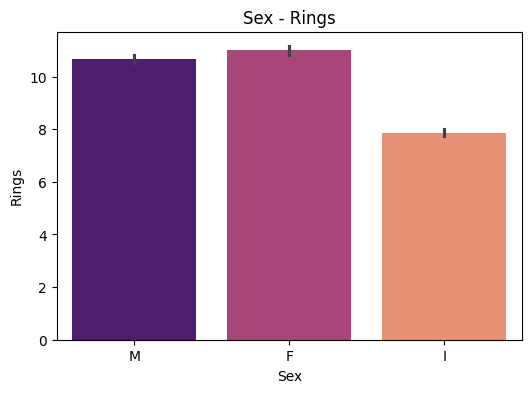

In [39]:
plt.figure(figsize=(6,4))

sns.barplot(x='Sex', y='Rings', data = df, palette='magma', hue='Sex')
plt.title('Sex - Rings')
plt.show();

In [40]:
df.groupby('Sex')["Rings"].mean().sort_values()

Sex
I     7.873626
M    10.678645
F    11.001376
Name: Rings, dtype: float64

Видно, что особи с явными половыми признаками, в среднем, старше особей без них

Однофакторный анализ показал, что у всех переменных есть некоторая связь с целевой переменной  
Больше всего с целевой переменной коррелирует `Shell weight`, меньше всего - `Shucked weight`  

Также были обнаружены аномальные значения в столбце `Height`. В будущем может возникнуть необходимость корректно их обработать

## Связь между количественными переменными

#### Корреляция Пирсона

<Axes: >

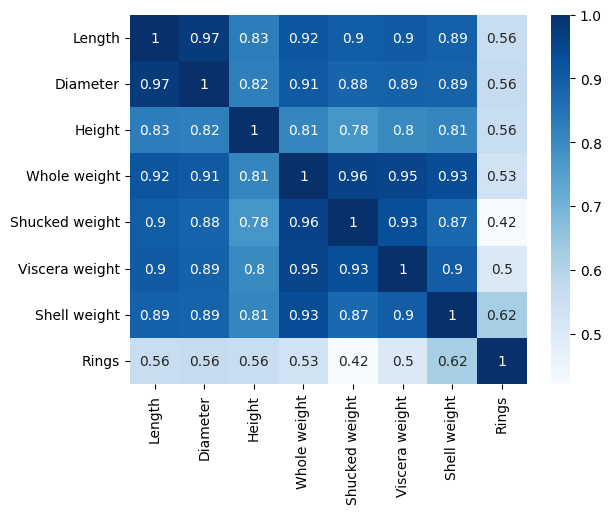

In [41]:
corr = df.corr(numeric_only=True)

sns.heatmap(corr, cmap="Blues", annot=True)

In [42]:
corr["Rings"].abs().sort_values(ascending=False)

Rings             1.000000
Shell weight      0.622547
Diameter          0.563262
Height            0.557625
Length            0.556464
Whole weight      0.531910
Viscera weight    0.503562
Shucked weight    0.420597
Name: Rings, dtype: float64

#### Корреляция Спирмана

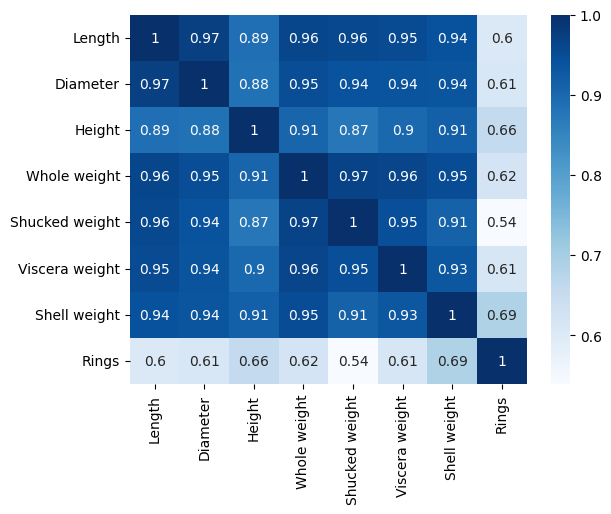

In [43]:
corr = df.corr(method='spearman', numeric_only=True)

sns.heatmap(corr, cmap="Blues", annot=True);

In [44]:
corr["Rings"].abs().sort_values(ascending=False)

Rings             1.000000
Shell weight      0.685760
Height            0.657403
Whole weight      0.621463
Viscera weight    0.613930
Diameter          0.611372
Length            0.603954
Shucked weight    0.538956
Name: Rings, dtype: float64

#### Корреляция Кендалла

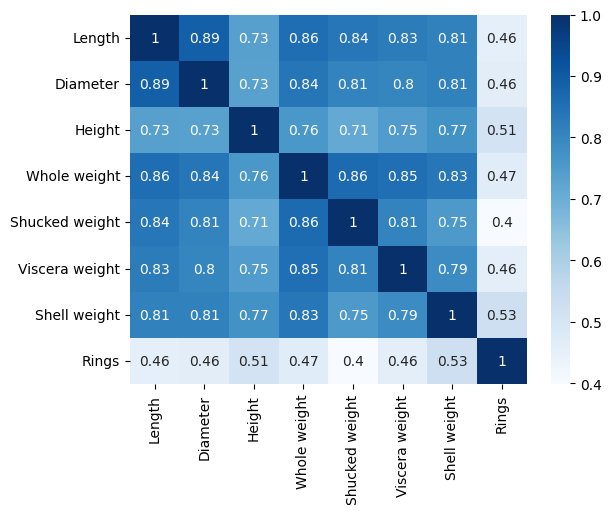

In [45]:
corr = df.corr(method='kendall', numeric_only=True)

sns.heatmap(corr, cmap="Blues", annot=True);

In [46]:
corr["Rings"].abs().sort_values(ascending=False)

Rings             1.000000
Shell weight      0.528260
Height            0.509180
Whole weight      0.468076
Diameter          0.464094
Viscera weight    0.460982
Length            0.456897
Shucked weight    0.398754
Name: Rings, dtype: float64

По матрицам корреляций видно, что у всех количественных переменных есть положительные корреляции между собой  
При этом корреляция с целевой переменной самая невыраженная

Ещё раз посмотрим на переменные датасета

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4175 non-null   object 
 1   Length          4175 non-null   float64
 2   Diameter        4175 non-null   float64
 3   Height          4175 non-null   float64
 4   Whole weight    4175 non-null   float64
 5   Shucked weight  4175 non-null   float64
 6   Viscera weight  4175 non-null   float64
 7   Shell weight    4175 non-null   float64
 8   Rings           4175 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.7+ KB


У нас всего одна категориальная переменная, поэтому использовать V-меру Крамера не имеет смысла  
Однако, посмотрим, есть ли зависимость между переменной `Sex` и количественными переменными методом ANOVA

#### ANOVA

In [48]:
numerical_columns = df.select_dtypes(exclude=['object']).columns
numerical_columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

In [49]:
from scipy.stats import f_oneway

In [50]:
Data = []

for num_col in tqdm.tqdm(numerical_columns):
    CategoryGroupLists = df.groupby("Sex")[num_col].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)

    if AnovaResults[1] >= 0.05:
        Data.append({'Category' : "Sex", 'Numerical' : num_col, 'Is correlated' : 'No'})
    else:
        Data.append({'Category' : "Sex", 'Numerical' : num_col, 'Is correlated' : 'Yes'})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

100%|██████████| 8/8 [00:00<00:00, 980.89it/s]


,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Height,Yes
3,Sex,Whole weight,Yes
4,Sex,Shucked weight,Yes
5,Sex,Viscera weight,Yes
6,Sex,Shell weight,Yes
7,Sex,Rings,Yes


Результаты теста показали, что категориальная переменная `Sex` имеет корреляции со всеми количественными переменными

## Исследование целевой переменной

Построим гистограмму для целевой переменной

<Axes: xlabel='Rings', ylabel='Count'>

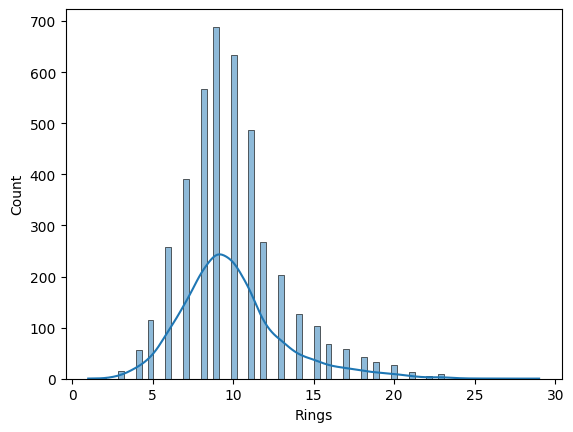

In [51]:
sns.histplot(data = df['Rings'], kde = True)

По своей структуре распределение выглядит как нормальное, с правой ассиметрией

In [52]:
df["Rings"].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

count    4175.000000
mean        9.935090
std         3.224227
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
95%        16.000000
max        29.000000
Name: Rings, dtype: float64

In [53]:
len(df.query("Rings >= 20")) / len(df)

0.014850299401197605

В данных присутствует тяжелый хвост. Значений, где количество колец больше 20, менее 2% от общих данных  
Есть вероятность, что обученная модель будет плохо предсказывать более взрослых особей

## Сравнение работы pandas и polars

Создадим датасет размером более 1.000.000 строк

In [54]:
df_big = df.copy()

In [55]:
while len(df_big) < 1_000_000:
    df_big = pd.concat([df_big, df])

In [56]:
len(df_big)

1002000

Сохраняем в файл

In [57]:
big_data_path = Path("data/big.csv")
df_big.to_csv(big_data_path)

Сравним скорость загрузки из файла

### Скорость загрузки

In [58]:
import time

Для чистоты эксперимента проведём по 10 измерений для каждой библиотеки, чтобы усреднить результат

In [59]:
num_measures = 10

#### Pandas

In [60]:
pandas_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    df_big = pd.read_csv(big_data_path)
    end_time = time.time()
    pandas_work_times.append(end_time - start_time)
pandas_mean_time = np.mean(pandas_work_times)

#### Polars

In [61]:
polars_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    pl_df_big = pl.read_csv(big_data_path)
    end_time = time.time()
    polars_work_times.append(end_time - start_time)
polars_mean_time = np.mean(polars_work_times)

In [62]:
print(f"Среднее время работы Pandas: {pandas_mean_time:.5f} с")
print(f"Среднее время работы Polars: {polars_mean_time:.5f} с")
if polars_mean_time < pandas_mean_time:
    print(f"Polars быстрее Pandas на {pandas_mean_time - polars_mean_time:.5f} с")
    print(f"Polars быстрее Pandas в {pandas_mean_time / polars_mean_time:.2f} раз(а)")
else:
    print(f"Pandas быстрее Polars на {polars_mean_time - pandas_mean_time:.5f} с")
    print(f"Pandas быстрее Polars в {polars_mean_time / pandas_mean_time:.2f} раз(а)")

Среднее время работы Pandas: 0.24295 с
Среднее время работы Polars: 0.02019 с
Polars быстрее Pandas на 0.22276 с
Polars быстрее Pandas в 12.03 раз(а)


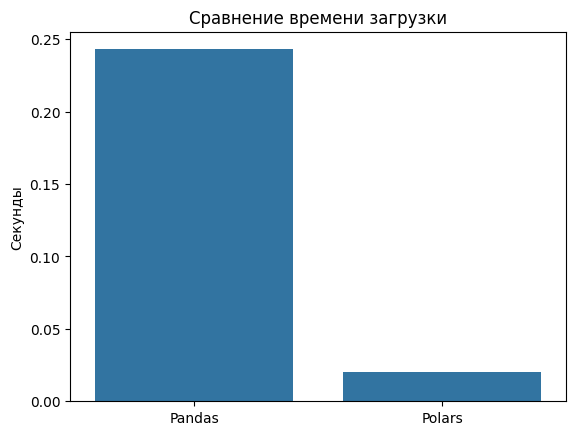

In [63]:
sns.barplot({"Pandas": pandas_mean_time, "Polars": polars_mean_time});
plt.title("Сравнение времени загрузки");
plt.ylabel("Секунды");

Как видно, при загрузке данных из файла Polars заметно превосходит Pandas по скорости выполнения

Сравним скорость фильтрации данных

### Скорость фильтрации

#### Pandas

In [64]:
pandas_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    df_big.query("Height > 0.1")
    end_time = time.time()
    pandas_work_times.append(end_time - start_time)
pandas_mean_time = np.mean(pandas_work_times)

#### Polars

In [65]:
polars_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    pl_df_big.lazy().filter(pl.col("Height") > 0.1).collect()
    end_time = time.time()
    polars_work_times.append(end_time - start_time)
polars_mean_time = np.mean(polars_work_times)

In [66]:
print(f"Среднее время работы Pandas: {pandas_mean_time:.5f} с")
print(f"Среднее время работы Polars: {polars_mean_time:.5f} с")
if polars_mean_time < pandas_mean_time:
    print(f"Polars быстрее Pandas на {pandas_mean_time - polars_mean_time:.5f} с")
    print(f"Polars быстрее Pandas в {pandas_mean_time / polars_mean_time:.2f} раз(а)")
else:
    print(f"Pandas быстрее Polars на {polars_mean_time - pandas_mean_time:.5f} с")
    print(f"Pandas быстрее Polars в {polars_mean_time / pandas_mean_time:.2f} раз(а)")

Среднее время работы Pandas: 0.01052 с
Среднее время работы Polars: 0.00462 с
Polars быстрее Pandas на 0.00589 с
Polars быстрее Pandas в 2.27 раз(а)


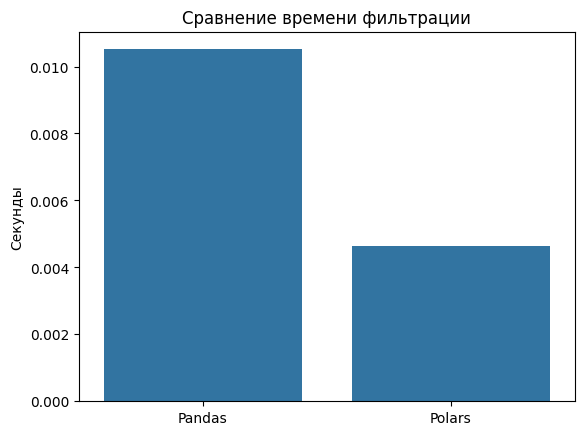

In [67]:
sns.barplot({"Pandas": pandas_mean_time, "Polars": polars_mean_time});
plt.title("Сравнение времени фильтрации");
plt.ylabel("Секунды");

При фильтрации данных Polars тоже быстрее, чем Pandas, но разница уже не такая значительная

Сравним скорость агрегации данных

### Скорость агрегации данных

#### Pandas

In [68]:
pandas_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    df_big.groupby("Sex").agg(
        {
            'Rings' : 'median',
            'Height' : 'mean',
            'Length' : 'mean',
            'Diameter' : 'mean',
            'Whole weight' : 'median',
            'Shucked weight' : 'median',
            'Viscera weight' : 'median',
            'Shell weight' : 'median'
        }
    )
    end_time = time.time()
    pandas_work_times.append(end_time - start_time)
pandas_mean_time = np.mean(pandas_work_times)

#### Polars

In [69]:
polars_work_times = list()

for _ in range(num_measures):
    start_time = time.time()
    pl_df_big.lazy().group_by("Sex").agg(
        [
            pl.median("Rings"),
            pl.mean("Height"),
            pl.mean("Length"),
            pl.mean("Diameter"),
            pl.median("Whole weight"),
            pl.median("Shucked weight"),
            pl.median("Viscera weight"),
            pl.median("Shell weight")
        ]
    ).collect()
    end_time = time.time()
    polars_work_times.append(end_time - start_time)
polars_mean_time = np.mean(polars_work_times)

In [70]:
print(f"Среднее время работы Pandas: {pandas_mean_time:.5f} с")
print(f"Среднее время работы Polars: {polars_mean_time:.5f} с")
if polars_mean_time < pandas_mean_time:
    print(f"Polars быстрее Pandas на {pandas_mean_time - polars_mean_time:.5f} с")
    print(f"Polars быстрее Pandas в {pandas_mean_time / polars_mean_time:.2f} раз(а)")
else:
    print(f"Pandas быстрее Polars на {polars_mean_time - pandas_mean_time:.5f} с")
    print(f"Pandas быстрее Polars в {polars_mean_time / pandas_mean_time:.2f} раз(а)")

Среднее время работы Pandas: 0.07658 с
Среднее время работы Polars: 0.02524 с
Polars быстрее Pandas на 0.05134 с
Polars быстрее Pandas в 3.03 раз(а)


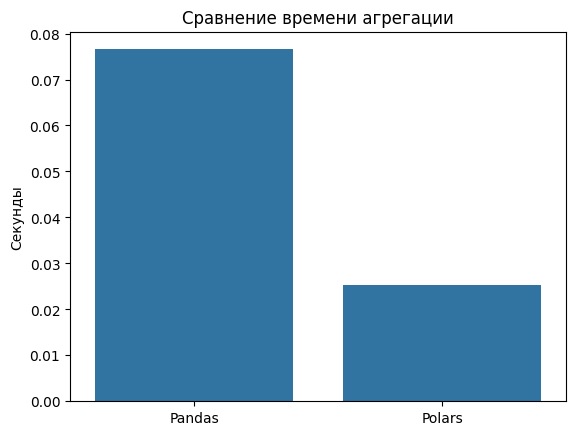

In [71]:
sns.barplot({"Pandas": pandas_mean_time, "Polars": polars_mean_time});
plt.title("Сравнение времени агрегации");
plt.ylabel("Секунды");

Как и в случае с фильтрацией, агрегация данных с помощью библиотеки Polars происходит быстрее

В целом, Polars работает быстрее, чем Pandas. При работе с большими объёмами данных стоит отдать предпочтение Polars  